# Average hemodynamic response

In [1]:
from wfield import *

folder = 'd:/data/DemoRec_new/'
SVT = np.load(pjoin(folder,'SVT.npy'))
SVT_470 = SVT[:,::2]
SVT_405 = SVT[:,1::2]
SVT_corr = np.load(pjoin(folder,'SVTcorr.npy'))
U = np.load(pjoin(folder,'U.npy'))
T = np.load(pjoin(folder,'T.npy'))

# filter and interpolate
t = np.arange(SVT_470.shape[1]*2) # interpolate the violet
from scipy.interpolate import interp1d
SVT_405 = interp1d(t[1::2],SVT_405,axis=1,
                   fill_value='extrapolate')(t[0::2])
freq_highpass = 0.1
fs = 33.
SVT_470 = highpass(SVT_470,w = freq_highpass, fs = fs).astype(np.float32)
SVT_405 = highpass(SVT_405,w = freq_highpass, fs = fs).astype(np.float32)

# Apply the transform, prepare for plotting
lmarks = load_allen_landmarks(pjoin(folder,'dorsal_cortex_landmarks.json'))
ccf_regions,proj,brain_outline = allen_load_reference('dorsal_cortex')
bout = brain_outline/lmarks['resolution'] + np.array(lmarks['bregma_offset'])

mask = contour_to_mask(*bout.T,dims = U.shape[:-1])

if 'dims' in dir():
    U = U.reshape(dims)

# warp and mask U, first make boarders zero
from wfield.imutils import mask_to_3d
U[:,0,:] = 0
U[0,:,:] = 0
U[-1,:,:] = 0
U[:,-1,:] = 0
U = np.stack(runpar(im_apply_transform,
                    U.transpose([2,0,1]),
                    M = lmarks['transform']))
U[mask_to_3d(mask,U.shape)==0] = np.nan
U = U.transpose([1,2,0])

In [2]:
# trial averages
trialstart = np.load(pjoin(folder,'stim_onsets.npy'))

SVT_405 = np.stack([SVT_405[:,o-90:o+150] for o in trialstart[:201]]).mean(axis=0)
SVT_470 = np.stack([SVT_470[:,o-90:o+150] for o in trialstart[:201]]).mean(axis=0)
SVT_corr = np.stack([SVT_corr[:,o-90:o+150] for o in trialstart[:201]]).mean(axis=0)

In [3]:
s_violet = SVDStack(U,np.dot(T,SVT_405)) # violet channel==0
s_blue = SVDStack(U,SVT_470) # blue channel
s_corr = SVDStack(U,SVT_corr) # corrected

In [ ]:
# Movies 
%matplotlib notebook
fig = plt.figure()
# fig.add_subplot(1,3,1)
# nb_play_movie(s_violet,clim = [-.02,0.02],cmap='RdBu_r')
# fig.add_subplot(1,3,2)
nb_play_movie(s_violet,clim = [-.02,0.02],cmap='RdBu_r')
# fig.add_subplot(1,3,3)
# nb_play_movie(s_corr,clim = [-.05,0.05],cmap='RdBu_r')


<IPython.core.display.Javascript object>


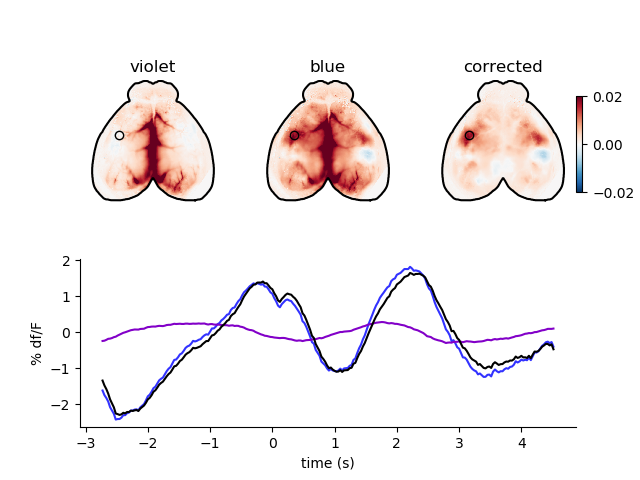

In [17]:
# the actual plot
frame = 168#104
fig = plt.figure()
ax = []
for e,i in enumerate([s_violet[frame],s_blue[frame],s_corr[frame]]):
    ax.append(fig.add_subplot(2,3,e+1))
    plt.plot(bout[:,0],bout[:,1],'k')
    plt.imshow(i,
               cmap = 'RdBu_r',clim = [-0.02,0.02])
    plt.axis('off')
ax[0].set_title('violet')
ax[1].set_title('blue')
ax[2].set_title('corrected')
xy = [170,240]
for a in ax:
    a.plot(*xy,'ko',markerfacecolor='none')


fig.add_subplot(2,1,2)
# plt.colorbar(shrink = 0.3)
tmp = np.zeros_like(s_blue[frame])
tmp[xy[1]-10:xy[1]+10,xy[0]-10:xy[0]+10] = 1
idx = np.ravel_multi_index(np.where(tmp == 1),s_blue.shape[1:])
t = np.nanmean(s_blue.Uflat[idx,:].dot(s_blue.SVT),axis = 0)
x  = (np.arange(len(t))-90)/fs
plt.plot(x,t*100,color=np.array([50,50,255])/255)
t = np.nanmean(s_violet.Uflat[idx,:].dot(s_violet.SVT),axis = 0)
plt.plot(x,t*100,color=np.array([130,0,200])/255)
t = np.nanmean(s_corr.Uflat[idx,:].dot(s_corr.SVT),axis = 0)
plt.plot(x,t*100,'k')

plt.ylabel('% df/F')
plt.xlabel('time (s)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
cax = fig.add_axes([.9,.6,.01,.2])
plt.colorbar(cax = cax)
plt.savefig('hemodynamic_correction_fig_average_newRec.pdf')

# Landmarks figure

<IPython.core.display.Javascript object>


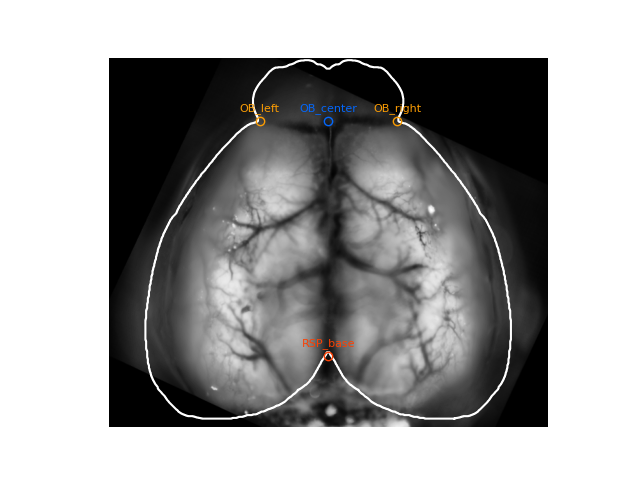

#fc9d03
#0367fc
#fc9d03
#fc4103


In [251]:
plt.matplotlib.rcParams['pdf.fonttype'] = 42
plt.matplotlib.rcParams['ps.fonttype'] = 42

lmarks = load_allen_landmarks('./dorsal_cortex_landmarks.json')
avg  = np.load('./frames_average.npy')
im = im_apply_transform(avg[0],lmarks['transform'])
plt.figure()
plt.imshow(im_adapt_hist(im.astype('uint16'),10),clim = [0,65000],
           alpha = 1,cmap='gray')
plt.plot(bout[:,0],bout[:,1],'w')
for i,x in enumerate((np.vstack([lmarks['landmarks'].x,
                                 lmarks['landmarks'].y]).T/
                      lmarks['resolution'] + lmarks['bregma_offset'])):
    color = lmarks['landmarks'].color.iloc[i]
    print(color)
    plt.plot(x[0],x[1],'o',markeredgecolor=color,
             markerfacecolor = 'none')
    plt.text(x[0],x[1]-10,lmarks['landmarks'].name.iloc[i],color=color,
             va='bottom',ha='center',fontsize=8)

plt.axis('off')
plt.savefig('ref_landmarks.pdf')